In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import poisson, chi2, expon, binom
from scipy.optimize import curve_fit, minimize
from functools import partial 
from scipy.integrate import quad
from scipy.special import gammaln
import pandas as pd
import time
import random as rnd
from tqdm import tqdm
import math 
import sympy 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import csv

colors=['darkcyan','indianred','#fb8b24','#392f5a',  'palegoldenrod','olivedrab']


## Defino funciones que uso

In [2]:
#errores del histograma
def errores(histo,rep):
    total=histo.sum()
    p_i=histo/total
    err_y=np.sqrt(total/rep*p_i*(1-p_i))
    return err_y

In [3]:
def ln_poisson_bin(n, nu): 
    return(n*np.log(nu)-gammaln(n+1)-nu)

def lnL(mu,theta,n,m,sM,tau=1):
    lnL=0
    for i in range(len(n)):
        on = ln_poisson_bin(n[i],mu*sM[i]+theta)
        off = ln_poisson_bin(m[i],tau*theta)
        lnL += on+off 
        return lnL
    
def mlnL2(params,kON,kOFF,sM,tau):
    mu, theta = params[0], params[1]
    return -1*lnL(mu,theta,kON,kOFF,sM,tau)

def mlnL1(params,mu,kON,kOFF,sM,tau):
    theta = params[0]
    return -1*lnL(mu,theta,kON,kOFF,sM,tau)


In [4]:
def p_val(mu, kON, kOFF, sM, tau, mu_hat, theta_hat):
        initial_guess = [0.1]
        bounds = ((1e-5,10),) #limites para mu y theta 
        result = minimize(mlnL1, initial_guess, args=(mu, kON, kOFF, sM, tau), bounds=bounds)
        theta_hat_hat = result.x
        LLR = -2*(lnL(mu,theta_hat_hat,kON,kOFF,sM, tau)[0]- lnL(mu_hat,theta_hat,kON,kOFF,sM, tau))
        pval = chi2.sf(LLR, df=1, scale=1)
        return(pval, LLR)

## Defino mis datos

In [5]:
kON=np.array([4]) #n
kOFF=np.array([0]) #m
binsize=10 # eV
val=102996*14.9/1000000  #--> rate[dru]*10eV  ==> Nev = rate*exposure[g day]/1000 kg / 1000 eV   massa mCP = 1eV  dru = eventos/kg/day/keV
sM=np.array([val])
expoON=14.9 # g day
expoOFF=3.5 # g day
tau=expoON/expoOFF
print(val,tau)

#minimizamos el denominador de (2)

initial_guess = [0,100]
bounds = ((1e-5,10),(1e-10,1000))
result = minimize(mlnL2, initial_guess, args=(kON, kOFF, sM, tau), bounds=bounds)
mu_hat, theta_hat = result.x
lnL_den = lnL(mu_hat,theta_hat,kON,kOFF,sM, tau)
print("Optimización del denominador:")
print("Valor óptimo de mu:", round(mu_hat,3))
print("Valor óptimo de theta:", round(theta_hat,3))
print("Valor óptimo de Log Likehood", round(lnL_den,3))
print('')


#minimizamos el numerador de (2)
mu=mu_hat
initial_guess2 = [1]  
bounds2 = ((1e-5,10),)

result2 = minimize(mlnL1, initial_guess2, args=(mu, kON, kOFF, sM, tau), bounds=bounds2)
theta_hat_hat = result2.x
lnL_num = lnL(mu,theta_hat_hat,kON,kOFF,sM, tau)
print("Optimización del numerador:")
print(f"Valor óptimo de theta para mu = {np.round(mu,3)}:", round(theta_hat_hat[0],3))
print("Valor óptimo de Log Likehood", round(lnL_num[0],3))

#calculo el cociente

LLR = -2*(lnL_num[0]-lnL_den)
print("Valor LLR", round(LLR,3)) #chequeo, dan 0 así que bien

pval = chi2.sf(LLR, df=1) #la sf es 1-cdf
print("p-value", round(pval,3)) #chequeo, dan 0 así que bien

t_mu = -2*(lnL(mu,theta_hat_hat,kON,kOFF,sM, tau)[0]-lnL_den) #en funcion de mu
pval_mu = chi2.sf(t_mu, df=1, scale=1)
delta = 0.01
mu = mu_hat + delta
alpha = 0.1

while pval > alpha:
    pval, LLR = p_val(mu, kON, kOFF, sM, tau, mu_hat, theta_hat) 
    mu += delta
    
print('')    
print(r'$\mu$ con 90$\%$ CL', mu)
print(r'p-value', pval)
print(r'LLR', LLR)

print(r'$\epsilon$', mu**(1/4))

1.5346404000000002 4.257142857142857
Optimización del denominador:
Valor óptimo de mu: 2.606
Valor óptimo de theta: 0.0
Valor óptimo de Log Likehood -1.633

Optimización del numerador:
Valor óptimo de theta para mu = 2.606: 0.0
Valor óptimo de Log Likehood -1.633
Valor LLR 0.0
p-value 0.993

$\mu$ con 90$\%$ CL 5.386473586717785
p-value 0.09973804246607162
LLR 2.709727257728012
$\epsilon$ 1.523442733457072


### Ahora para Atucha
¿Cómo tenemos en cuenta los errores?

In [6]:
kON_a=np.array([11186]) #n
kOFF_a=np.array([8694]) #m
binsize=10 # eV
val_a=102996*0.604391/1000000  #--> rate[dru]*10eV  ==> Nev = rate*exposure[g day]/1000 kg / 1000 eV   massa mCP = 1eV  dru = eventos/kg/day/keV
sM_a=np.array([val])
expoON_a=0.604391 # g day
expoOFF_a=0.216861# g day
tau_a=expoON_a/expoOFF_a
print(val_a,tau_a)

#minimizamos el denominador de (2)

initial_guess_a = [500,1000]
bounds_a = ((1e-5,10000),(1e-10,10000000))
result_a = minimize(mlnL2, initial_guess_a, args=(kON_a, kOFF_a, sM_a, tau_a), bounds=bounds_a)
mu_hat_a, theta_hat_a = result_a.x
lnL_den_a = lnL(mu_hat_a,theta_hat_a,kON_a,kOFF_a,sM_a, tau_a)
print("Optimización del denominador:")
print("Valor óptimo de mu:", round(mu_hat_a,3))
print("Valor óptimo de theta:", round(theta_hat_a,3))
print("Valor óptimo de Log Likehood", round(lnL_den_a,3))
print('')


#minimizamos el numerador de (2)
mu_a=mu_hat_a
initial_guess2_a = [1]  
bounds2_a = ((1e-5,10000),)

result2_a = minimize(mlnL1, initial_guess2_a, args=(mu_a, kON_a, kOFF_a, sM_a, tau_a), bounds=bounds2_a)
theta_hat_hat_a = result2_a.x
lnL_num_a = lnL(mu_a,theta_hat_hat_a,kON_a,kOFF_a,sM_a, tau_a)
print("Optimización del numerador:")
print(f"Valor óptimo de theta para mu = {np.round(mu_a,3)}:", round(theta_hat_hat_a[0],3))
print("Valor óptimo de Log Likehood", round(lnL_num_a[0],3))

#calculo el cociente

LLR_a = -2*(lnL_num_a[0]-lnL_den_a)
print("Valor LLR", round(LLR,3)) #chequeo, dan 0 así que bien

pval_a = chi2.sf(LLR_a, df=1) #la sf es 1-cdf
print("p-value", round(pval_a,3)) #chequeo, dan 0 así que bien

t_mu_a = -2*(lnL(mu_a,theta_hat_hat_a,kON_a,kOFF_a,sM_a, tau_a)[0]-lnL_den_a) #en funcion de mu
pval_mu_a = chi2.sf(t_mu_a, df=1, scale=1)
delta_a = 0.01
mu_a = mu_hat_a + delta_a
alpha_a = 0.1

while pval_a > alpha_a:
    pval_a, LLR_a = p_val(mu_a, kON_a, kOFF_a, sM_a, tau_a, mu_hat_a, theta_hat_a) 
    mu_a += delta_a
    
print('')    
print(r'$\mu$ con 90$\%$ CL', mu_a)
print(r'p-value', pval_a)
print(r'LLR', LLR)

print(r'$\epsilon$', mu_a**(1/4))

0.062249855436 2.7869972009720514
Optimización del denominador:
Valor óptimo de mu: 5256.768
Valor óptimo de theta: 3119.037
Valor óptimo de Log Likehood -11.034

Optimización del numerador:
Valor óptimo de theta para mu = 5256.768: 3118.393
Valor óptimo de Log Likehood -11.035
Valor LLR 2.71
p-value 0.976

$\mu$ con 90$\%$ CL 5256.787678054281
p-value 0.0
LLR 2.709727257728012
$\epsilon$ 8.514910923179892


In [7]:

def calc_epsilon(rate, ctes, bounds):
    kON, kOFF, expoON, expoOFF, binsize, tau = ctes
    val=binsize*rate*14.9/1000000 #rate eventos/(kg keV day), un mil viene de pasar de kg a g y el otro de pasar de keV a eV
    sM=np.array([val])
    
    #minimizamos el denominador de (2)
    initial_guess = [0,100]
    
    result = minimize(mlnL2, initial_guess, args=(kON, kOFF, sM, tau), bounds=bounds)
    mu_hat, theta_hat = result.x
    lnL_den = lnL(mu_hat,theta_hat,kON,kOFF,sM, tau)
   
    #minimizamos el numerador de (2)
    mu=mu_hat
    initial_guess2 = [1]  
    bounds2 = ((1e-5,10),)
    result2 = minimize(mlnL1, initial_guess2, args=(mu, kON, kOFF, sM, tau), bounds=bounds2)
    theta_hat_hat = result2.x
    lnL_num = lnL(mu,theta_hat_hat,kON,kOFF,sM, tau)
    
    #calculo el cociente
    LLR = -2*(lnL_num[0]-lnL_den)
    pval = chi2.sf(LLR, df=1) #la sf es 1-cdf
    
    #itero sobre mu
    t_mu = -2*(lnL(mu,theta_hat_hat,kON,kOFF,sM, tau)[0]-lnL_den) #en funcion de mu
    pval_mu = chi2.sf(t_mu, df=1, scale=1)
    delta = 0.01
    mu = mu_hat + delta
    alpha = 0.1

    while pval > alpha:
        pval, LLR = p_val(mu, kON, kOFF, sM, tau, mu_hat, theta_hat) 
        mu += delta
        
    epsilon = mu**(1/4)
    
    return epsilon

In [8]:
kON=np.array([4]) #n
kOFF=np.array([0]) #m
expoON=14.9 # g day
expoOFF=3.5 # g day
binsize=10 # eV
tau=expoON/expoOFF

rate10 = [66041.8, 10273.7, 84518.9, 29087.5, 6413.61, 102996, 47564.7, 4219.94, 2685.99, 1711.11, 632.606] #rate*10eV
m_mev=[0.0001, 0.1, 1e-5, 0.01, 0.15, 1e-6, 0.001, 0.2, 0.25, 0.3, 0.4] #EN MEV
m_mev=np.array([m_mev])[0] 
rate= (np.array([rate10])*0.1)[0] #por como dario nos dio los datos
ctes=kON, kOFF, expoON, expoOFF, binsize, tau
bounds = ((1e-5,10),(1e-10,1000))
print(rate)

[ 6604.18    1027.37    8451.89    2908.75     641.361  10299.6
  4756.47     421.994    268.599    171.111     63.2606]


In [12]:
epsilons = np.array([])
for i in tqdm(range(len(rate))):
    epsilon_i = calc_epsilon(rate[i], ctes, bounds)
    epsilons =np.append(epsilons, epsilon_i)

epsilon=epsilons*10**(-6)

100%|██████████| 11/11 [03:24<00:00, 18.55s/it]


### Atucha

In [15]:
kON_a=np.array([187]) #n
kOFF_a=np.array([24]) #m
binsize=10 # eV
val_a=102996*(25/8)*0.604391/1000000  #--> rate[dru]*10eV  ==> Nev = rate*exposure[g day]/1000 kg / 1000 eV   massa mCP = 1eV  dru = eventos/kg/day/keV
sM_a=np.array([val])
expoON_a=0.604391*1000 # g day
expoOFF_a=0.216861*1000 # g day
tau_a=expoON_a/expoOFF_a



rate_a= (np.array([rate])*(25/8))[0] #paso de connie a atucha
ctes_a=kON_a, kOFF_a, expoON_a, expoOFF_a, binsize, tau_a
bounds_a = ((1,1000),(1,100000))

epsilons_a = np.array([])
for i in tqdm(range(len(rate_a))):
    epsilon_i_a = calc_epsilon(rate_a[i], ctes_a, bounds_a)
    epsilons_a =np.append(epsilons_a, epsilon_i_a)

epsilon_a=epsilons_a*10**(-6)

100%|██████████| 11/11 [1:20:00<00:00, 436.40s/it] 


### Texono

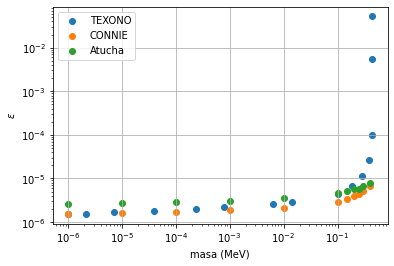

In [18]:
#GeV/c^2

csv_file_path = 'c:/Users/Zoe/Desktop/Labo 67/espectros/Texono_Limit_Data.csv'

m_gev_texono = []
epsilon_texono = []

# Open the CSV file
with open(csv_file_path, 'r') as file:
    csv_reader = csv.reader(file)

    # Iterate through each row in the CSV file
    for row in csv_reader:
        m_gev_texono.append(float(row[0]))
        epsilon_texono.append(float(row[1]))
      
m_gev_texono = np.array([m_gev_texono])
epsilon_texono = np.array([epsilon_texono]) 
m_mev_texono = m_gev_texono*10**(3)     

epsilon_texono=epsilon_texono[0]
m_mev_texono=m_mev_texono[0]

plt.scatter(m_mev_texono, epsilon_texono, label='TEXONO')
plt.scatter(m_mev, epsilon, label='CONNIE')
plt.scatter(m_mev, epsilon_a, label='Atucha')

plt.xlabel('masa (MeV)')
plt.ylabel(r'$\epsilon$')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show() 

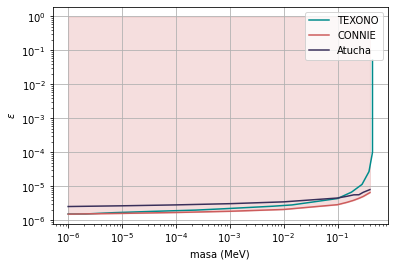

In [19]:
m_mev=np.sort(m_mev)
epsilon=np.sort(epsilon)
epsilon_a=np.sort(epsilon_a)
m_mev_texono=np.sort(m_mev_texono)
epsilon_texono=np.sort(epsilon_texono)


fill_value = 1.0
plt.plot(m_mev_texono, epsilon_texono, label='TEXONO', color=colors[0])
plt.plot(m_mev, epsilon, label='CONNIE', color=colors[1])
plt.plot(m_mev, epsilon_a, label='Atucha', color=colors[3])
plt.fill_between(m_mev, epsilon, fill_value, color=colors[1], alpha=0.2)


plt.xlabel('masa (MeV)')
plt.ylabel(r'$\epsilon$')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show() 